# E-Commerce Recommendation System

## Table of Contents


In [1]:
from google.colab import drive
drive.mount('/content/drive')m

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Importation of Packages

In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 2. Data Importation

In [3]:
dtypes = {
    "property": "object", 
    "timestamp": "int64",  
}

# Function to optimize data types (reduce memory usage)
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')  
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')  
    return df

# Load large CSV files using Dask with specified dtypes
def load_csv_dask(file_path):
    return dd.read_csv(file_path, dtype=dtypes)  

# Load & Process Events Data
events_ddf = load_csv_dask("/content/drive/MyDrive/E-commerce data/events.csv")
events_ddf["timestamp"] = dd.to_datetime(events_ddf["timestamp"], unit="ms")  # Convert timestamp

# Load & Process Item Properties Data
item_properties_1_ddf = load_csv_dask("/content/drive/MyDrive/E-commerce data/item_properties_part1.1.csv")
item_properties_2_ddf = load_csv_dask("/content/drive/MyDrive/E-commerce data/item_properties_part2.csv")

# Convert timestamp column in item properties datasets
item_properties_1_ddf["timestamp"] = dd.to_datetime(item_properties_1_ddf["timestamp"], unit="ms")
item_properties_2_ddf["timestamp"] = dd.to_datetime(item_properties_2_ddf["timestamp"], unit="ms")

# Merge both item properties datasets
item_properties_ddf = dd.concat([item_properties_1_ddf, item_properties_2_ddf])

# Load & Process Category Tree Data
category_tree_ddf = load_csv_dask("/content/drive/MyDrive/E-commerce data/category_tree.csv")

# Convert Dask DataFrames to Pandas
events_df = reduce_memory(events_ddf.compute())
item_properties_df = reduce_memory(item_properties_ddf.compute())
category_tree_df = category_tree_ddf.compute()

print(" Data loading complete! Converted to Pandas for easy analysis.")


 Data loading complete! Converted to Pandas for easy analysis.


## 3. Exploratory Data Analysis

### 3.1 Data Validation and Sanity Checks

#### 3.1.1 Events Data

In [4]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [5]:
events_df.tail()

,timestamp,visitorid,event,itemid,transactionid
2756096,2015-08-01 03:13:05.939,591435,view,261427,NaN
2756097,2015-08-01 03:30:13.142,762376,view,115946,NaN
2756098,2015-08-01 02:57:00.527,1251746,view,78144,NaN
2756099,2015-08-01 03:08:50.703,1184451,view,283392,NaN
2756100,2015-08-01 03:36:03.914,199536,view,152913,NaN


In [6]:
events_df.shape

(2756101, 5)

In [7]:
events_df.isna().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,2733644


In [8]:
# Percentage of null values in events data
print("\n3. Percentage of Null Values per Column:")
print((events_df.isnull().sum() / events_df.shape[0]) * 100)


3. Percentage of Null Values per Column:
timestamp         0.00000
visitorid         0.00000
event             0.00000
itemid            0.00000
transactionid    99.18519
dtype: float64


There are no missing values in the timestamp, visitorid, event and itemid except transactionid, which has 2,733,644 missing values. This is because, once an individual just views or adds to cart without making a transaction, he or she will not get a transaction id.

In [9]:
# handling missing values in the transactionid column.
# Fill missing transaction IDs with 0 (assuming NaN means no purchase)
events_df["transactionid"] = events_df["transactionid"].fillna(0)

In [10]:
# checking for missing values in event data after handling missing values in the transactionid column.
events_df.isna().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,0


There is no missing values in the events data.

In [11]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int32         
 2   event          object        
 3   itemid         int32         
 4   transactionid  float32       
dtypes: datetime64[ns](1), float32(1), int32(2), object(1)
memory usage: 73.6+ MB


In [12]:
events_df.describe()

,timestamp,visitorid,itemid,transactionid
count,2756101,2.756101e+06,2.756101e+06,2.756101e+06
mean,2015-07-09 06:48:08.348103680,7.019229e+05,2.349225e+05,7.191924e+01
min,2015-05-03 03:00:04.384000,0.000000e+00,3.000000e+00,0.000000e+00
25%,2015-06-05 04:23:14.792000,3.505660e+05,1.181200e+05,0.000000e+00
50%,2015-07-09 14:43:33.599000064,7.020600e+05,2.360670e+05,0.000000e+00
75%,2015-08-10 16:45:05.168000,1.053437e+06,3.507150e+05,0.000000e+00
max,2015-09-18 02:59:47.788000,1.407579e+06,4.668670e+05,1.767100e+04
std,NaN,4.056875e+05,1.341954e+05,9.147247e+02


In [13]:
# Unique values in each column
print("\n Unique Value Counts per Column:")
for col_name in events_df.columns:
    unique_vals = events_df[col_name].nunique()
    print(f"  {col_name}: {unique_vals}")


 Unique Value Counts per Column:
  timestamp: 2750455
  visitorid: 1407580
  event: 3
  itemid: 235061
  transactionid: 17672


In [14]:
# checking for duplicates in events data
events_df.duplicated().sum()

460

In [15]:
# dropping duplicate values
events_df.drop_duplicates(inplace=True)

In [16]:
events_df.duplicated().sum()

0

In [17]:
events_df['visitorid'].value_counts()

,count
visitorid,
1150086,7757
530559,4328
152963,3024
895999,2474
163561,2410
...,...
578031,1
643534,1
698825,1


In [18]:
events_counts = events_df['event'].value_counts()
events_counts

,count
event,
view,2664218
addtocart,68966
transaction,22457


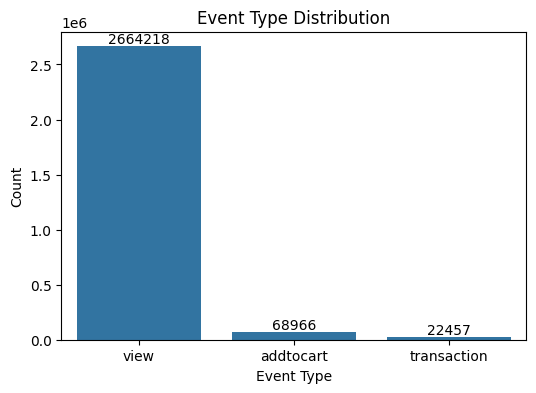

In [19]:
# visualizing events column using countplot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="event", data=events_df, order=events_counts.index)

# Add count labels
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), int(p.get_height()),
            ha='center', va='bottom', fontsize=10)

plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

In [20]:
# Group by visitorid to see how many events each user performed
user_events_counts = events_df.groupby('visitorid')['event'].count()
user_events_counts.head(10)

,event
visitorid,
0,3
1,1
2,8
3,1
4,1
5,1
6,6
7,3
8,1


In [21]:
events_df['itemid'].value_counts()

,count
itemid,
187946,3412
461686,2975
5411,2334
370653,1854
219512,1800
...,...
145333,1
113185,1
109819,1


#### 3.1.2 Sanity checks for the item_properties data

In [22]:
# Sanity checks for the item_properties data
item_properties_df.head()

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


In [23]:
item_properties_df.tail()

,timestamp,itemid,property,value
1545977,2015-06-07 03:00:00,236931,929,n12.000
1545978,2015-08-30 03:00:00,455746,6,150169 639134
1545979,2015-08-16 03:00:00,347565,686,610834
1545980,2015-06-07 03:00:00,287231,867,769062
1545981,2015-09-13 03:00:00,275768,888,888666 n10800.000 746840 1318567


In [24]:
item_properties_df.shape

(20275902, 4)

In [25]:
# checking for duplicated values
item_properties_df.duplicated().sum()

0

In [26]:
# checking for missing values
item_properties_df.isna().sum()

,0
timestamp,0
itemid,0
property,0
value,0


In [27]:
# Percentage of null Item_properties
print("\n3. Percentage of Null Values per Column:")
print((item_properties_df.isnull().sum() / item_properties_df.shape[0]) * 100)


3. Percentage of Null Values per Column:
timestamp    0.0
itemid       0.0
property     0.0
value        0.0
dtype: float64


There are no missing values in the item_properties

In [28]:
item_properties_df.describe()

,timestamp,itemid
count,20275902,2.027590e+07
mean,2015-06-24 14:42:23.682880256,2.333904e+05
min,2015-05-10 03:00:00,0.000000e+00
25%,2015-05-24 03:00:00,1.165160e+05
50%,2015-06-07 03:00:00,2.334830e+05
75%,2015-07-26 03:00:00,3.503040e+05
max,2015-09-13 03:00:00,4.668660e+05
std,NaN,1.348452e+05


In [29]:
item_properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 1545981
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   itemid     int32         
 2   property   object        
 3   value      object        
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 696.1+ MB


In [30]:
item_properties_df['itemid'].value_counts()

,count
itemid,
158903,468
254069,462
91855,461
150800,459
120386,444
...,...
251894,15
342400,14
73456,13


In [31]:
print("*** Top 10 Most Frequent Properties***")
item_properties_df['property'].value_counts().sort_values(ascending=False).head(10)

*** Top 10 Most Frequent Properties***


,count
property,
888,3000398
790,1790516
available,1503639
categoryid,788214
6,631471
283,597419
776,574220
678,481966
364,476486


In [32]:
# Unique values in each Item_properties column
print("\n Unique Value Counts per Column:")
for col_name in item_properties_df.columns:
    unique_vals = item_properties_df[col_name].nunique()
    print(f"  {col_name}: {unique_vals}")


 Unique Value Counts per Column:
  timestamp: 18
  itemid: 417053
  property: 1104
  value: 1966868


In [33]:
# Count how many properties each item has
item_properties_counts = item_properties_df.groupby('itemid')['property'].count()
print(item_properties_counts.head())
print("\n")
print("*** Distribution of 'property' count per item ***")
print(item_properties_counts.describe())

itemid
0    45
1    86
2    24
3    46
4    42
Name: property, dtype: int64


*** Distribution of 'property' count per item ***
count    417053.000000
mean         48.617087
std          27.385722
min          12.000000
25%          28.000000
50%          42.000000
75%          60.000000
max         468.000000
Name: property, dtype: float64


In [34]:
print("\nTop 10 value:")
item_properties_df['value'].value_counts().sort_values(ascending=False).head(10)


Top 10 value:


,count
value,
769062,1537247
0,863246
1,641420
679677,417054
1285872,417053
519769,417053
1116693,157243
1297729 n156.000 606827,120136
664227,118653


#### 3.1.3 Exploring the Category Tree Dataframe

In [35]:
category_tree_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [36]:
category_tree_df.tail()

,categoryid,parentid
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0
1668,761,395.0


In [37]:
print("*** Missing Values in category_tree *** ")
category_tree_df.isna().sum()

*** Missing Values in category_tree *** 


,0
categoryid,0
parentid,25


In [38]:
print(" --- Percentage of null values per column ---")
print((category_tree_df.isnull().sum() / category_tree_df.shape[0]) * 100)

 --- Percentage of null values per column ---
categoryid    0.000000
parentid      1.497903
dtype: float64


In [39]:
category_tree_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [40]:
category_tree_df.describe()

,categoryid,parentid
count,1669.000000,1644.000000
mean,849.285201,847.571168
std,490.195116,505.058485
min,0.000000,8.000000
25%,427.000000,381.000000
50%,848.000000,866.000000
75%,1273.000000,1291.000000
max,1698.000000,1698.000000


In [41]:
category_tree_df.duplicated().sum()

0

In [42]:
# filling missing values in the parentid column with '-1'
#category_tree_df["parentid"] = category_tree_df["parentid"].fillna(-1)

In [43]:
category_tree_df.isna().sum()

,0
categoryid,0
parentid,25


In [44]:
# Unique values in each column
print(" --- Unique Value Counts per Column: ---")
for col_name in category_tree_df.columns:
    unique_vals = category_tree_df[col_name].nunique()
    print(f"  {col_name}: {unique_vals}")

 --- Unique Value Counts per Column: ---
  categoryid: 1669
  parentid: 362


In [45]:
# Root categories are those with parentid == NaN
root_categories = category_tree_df[category_tree_df['parentid'].isna()]
print(f"\nRoot Categories (count={root_categories.shape[0]}):")
root_categories.head(10)


Root Categories (count=25):


,categoryid,parentid
5,231,NaN
589,791,NaN
861,1490,NaN
939,431,NaN
1111,755,NaN
1142,378,NaN
1208,1579,NaN
1211,1394,NaN
1322,659,NaN
1329,1057,NaN


In [46]:
# Exclude rows where parentid is null
non_null_parents = category_tree_df.dropna(subset=['parentid'])

parent_child_counts = non_null_parents.groupby('parentid')['categoryid'].count()
print("\n=== Distribution of child counts per parent ===")
print(parent_child_counts.describe())

print("\nTop 10 Parents by Number of Children:")
top_parents = parent_child_counts.sort_values(ascending=False).head(10)
print(top_parents)


=== Distribution of child counts per parent ===
count    362.000000
mean       4.541436
std        3.571152
min        1.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       31.000000
Name: categoryid, dtype: float64

Top 10 Parents by Number of Children:
parentid
250.0     31
1009.0    22
362.0     22
351.0     19
1259.0    18
1687.0    17
945.0     15
312.0     15
92.0      13
1482.0    13
Name: categoryid, dtype: int64


In [47]:
# Handling missing values in the parentid. since the percentage of missing data is small 1.2% we drop the values.
missing_parentid_count = category_tree_df['parentid'].isna().sum()
print(f"Number of missing 'parentid' values: {missing_parentid_count}")
category_tree_df.dropna(subset =['parentid'], inplace=True)

Number of missing 'parentid' values: 25


In [48]:
#Checking for missing values after dropping missing values in the parentid
category_tree_df.isna().sum()


,0
categoryid,0
parentid,0


## 3.2 Univariate Analysis

### 3.2.1 Events Dataframe

#### Numerical

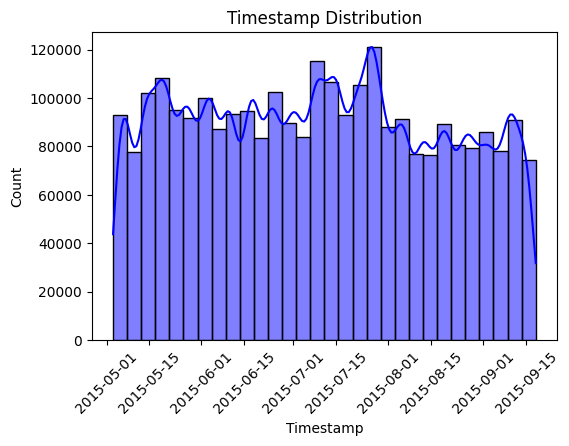

In [49]:
#Timestamp
plt.figure(figsize=(6,4))
sns.histplot(events_df['timestamp'], bins=30, kde=True, color='blue')
plt.title("Timestamp Distribution")
plt.xlabel("Timestamp")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

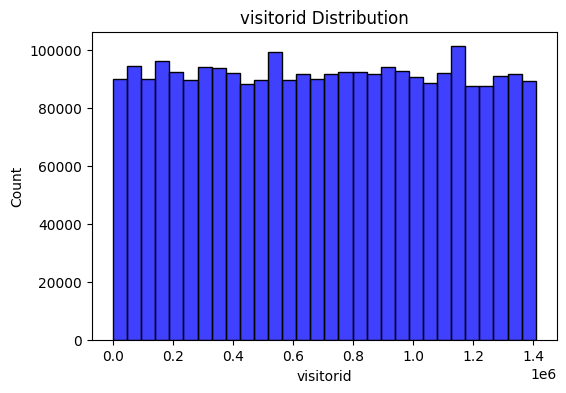

In [50]:
# visitorid
plt.figure(figsize=(6,4))
sns.histplot(events_df['visitorid'], bins=30, color='blue')
plt.title("visitorid Distribution")
plt.xlabel("visitorid")
plt.ylabel("Count")
plt.show()

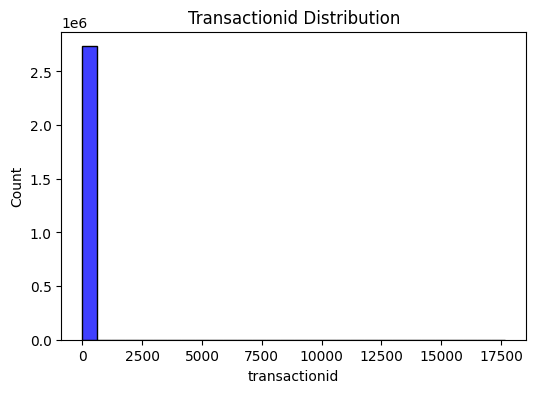

In [51]:
# transactionid
plt.figure(figsize=(6,4))
sns.histplot(events_df['transactionid'], bins=30, color='blue')
plt.title("Transactionid Distribution")
plt.xlabel("transactionid")
plt.ylabel("Count")
plt.show()

#### Categorical

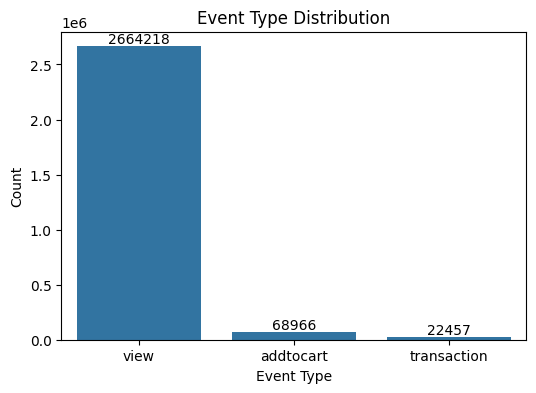

In [52]:
# event
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="event", data=events_df, order=events_counts.index)

# Add count labels
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), int(p.get_height()),
            ha='center', va='bottom', fontsize=10)

plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

### 3.2.2 Items Properties

#### Numeric

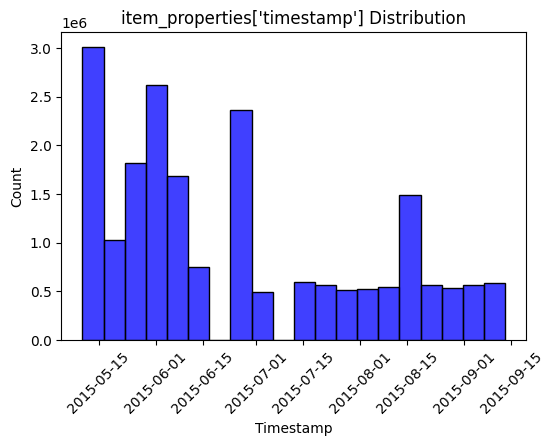

In [53]:
# Timestamp
plt.figure(figsize=(6,4))
sns.histplot(item_properties_df['timestamp'], bins=20, kde=False, color='blue')
plt.title("item_properties['timestamp'] Distribution")
plt.xlabel("Timestamp")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

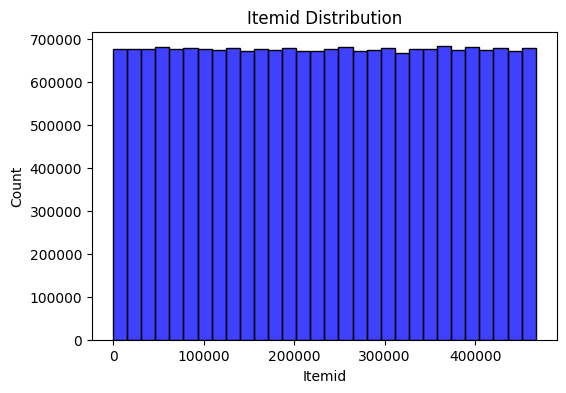

In [54]:
# Itemid
plt.figure(figsize=(6,4))
sns.histplot(item_properties_df['itemid'], bins=30, color='blue')
plt.title("Itemid Distribution")
plt.xlabel("Itemid")
plt.ylabel("Count")
plt.show()

#### Categorical

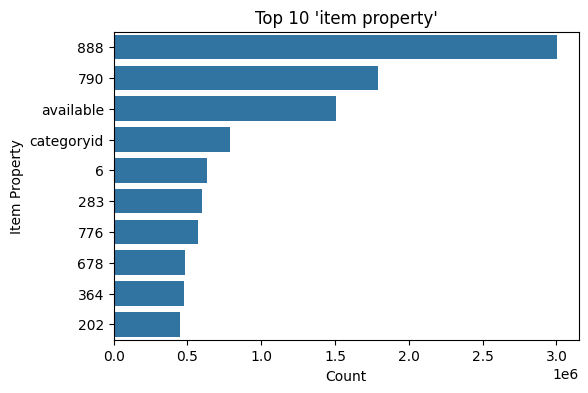

In [55]:
# Property
plt.figure(figsize=(6,4))
top_10_item_properties = item_properties_df['property'].value_counts().head(10)
sns.barplot(x=top_10_item_properties.values, y=top_10_item_properties.index, orient='h')
plt.title("Top 10 'item property'")
plt.xlabel("Count")
plt.ylabel("Item Property")
plt.show()

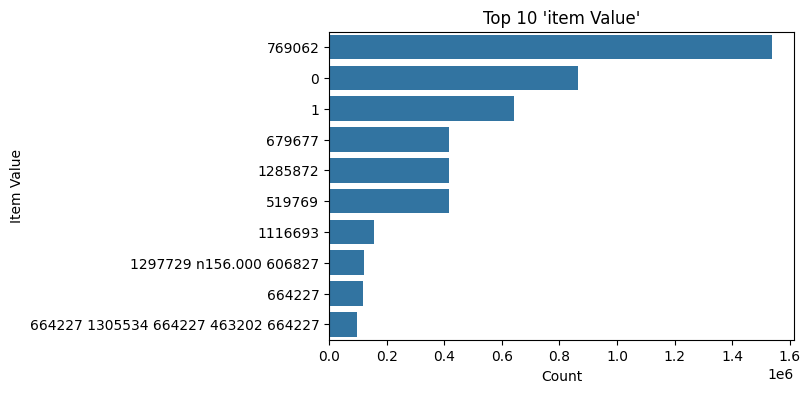

In [56]:
# value
plt.figure(figsize=(6,4))
top_10_item_value = item_properties_df['value'].value_counts().head(10)
sns.barplot(x=top_10_item_value.values, y=top_10_item_value.index, orient='h')
plt.title("Top 10 'item Value'")
plt.xlabel("Count")
plt.ylabel("Item Value")
plt.show()

### 3.2.3 Category Tree DataFrame

#### Numeric

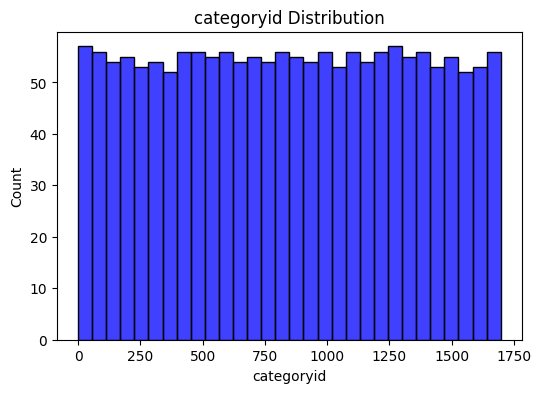

In [57]:
# categoryid
plt.figure(figsize=(6,4))
sns.histplot(category_tree_df['categoryid'], bins=30, color='blue')
plt.title("categoryid Distribution")
plt.xlabel("categoryid")
plt.ylabel("Count")
plt.show()

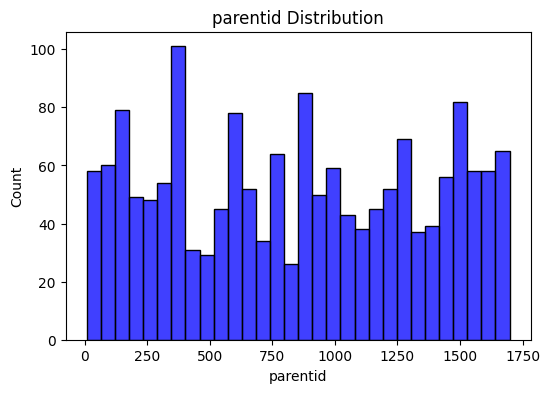

In [58]:
# parentid
plt.figure(figsize=(6,4))
sns.histplot(category_tree_df['parentid'], bins=30, color='blue')
plt.title("parentid Distribution")
plt.xlabel("parentid")
plt.ylabel("Count")
plt.show()

### 3.3 Bivariate Analysis

### 4. Research/ Analytical Questions

### 1. What are the top 10 items viewed by Customers?

In [ ]:
# Top items viewed by customer
top_view_items = events_df[events_df['event'] == 'view']['itemid'].value_counts().head(10)
print(top_view_items)

# Sorting values in descending order
top_view_items_sort = top_view_items.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_view_items_sort.index, y=top_view_items_sort.values)
plt.title('Top 10 Viewed Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.show()

### 2. What are the top items customers add to cart?

In [ ]:
# Sort values in ascending order for better visualization
# Top items Added to cart by customer
top_addtocart_item = events_df[events_df['event'] == 'addtocart']['itemid'].value_counts().head(10)
print(top_view_items)

top_addtocart_items = top_view_item.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_view_items.index, y=top_view_items.values)
plt.title('Top 10 Added to Cart Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.show()

### 3. How many customers purcahsed or did not purchase an item?

In [ ]:
# Customer who purchase items
print("***Customers who purchase Items***")
customer_purchase = events_df[events_df.transactionid.notnull()].visitorid.unique().size
print(customer_purchase)
print("\n")

# Customer who did not purchase items
print("*** Customers who did not purchase Items***")
customer_no_purchase = events_df[events_df.transactionid.isnull()].visitorid.unique().size
print(customer_no_purchase)

### 4. What time of day or day of the week has the highest number of purchases?

In [ ]:
# Extract hour from timestamp
print("***Time of the day which has the highest number of purchases***")
events_df['hour'] = events_df['timestamp'].dt.hour

# Purchases per hour
hourly_purchases = events_df[events_df['transactionid'].notnull()].groupby('hour')['visitorid'].nunique()

# Plot purchases by hour

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_purchases.index, y=hourly_purchases.values, marker='o')
plt.title('Purchases by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Purchases')
plt.xticks(range(0, 24))
plt.grid()
plt.show()

In [ ]:
print("***Day of the week which has the highest number of purchases***")
# Extract day of the week (0 = Monday, 6 = Sunday)
events_df['day_of_week'] = events_df['timestamp'].dt.dayofweek

# Count purchases per day of the week
daily_purchases = events_df[events_df['transactionid'].notnull()].groupby('day_of_week')['visitorid'].nunique()

# Mapping numbers to day names
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_purchases.index = day_labels

# Sort values in descending order (from highest to lowest purchases)
daily_purchases_sort = daily_purchases.sort_values(ascending=False)

# Plot purchases by day of the week
plt.figure(figsize=(10, 5))
sns.barplot(x=daily_purchases_sort.index, y=daily_purchases_sort.values, palette="Blues_r")
plt.title('Purchases by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Purchases')
plt.show()

### 5. What items are frequently viewed but least purchased?

In [ ]:
# Count views per item
item_views = events_df[events_df['event'] == 'view'].groupby('itemid')['visitorid'].nunique()

# Count purchases per item
item_purchases = events_df[events_df['transactionid'].notnull()].groupby('itemid')['visitorid'].nunique()

# Fill missing values with 0 (some items might not have been purchased)
item_purchases = item_purchases.reindex(item_views.index, fill_value=0)

# Calculate view-to-purchase ratio
view_to_purchase_ratio = item_views / (item_purchases + 1) 

# Identify top 10 items with highest views but lowest purchases
low_conversion_items = view_to_purchase_ratio.sort_values(ascending=False).head(10)

# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x=low_conversion_items.index, y=low_conversion_items.values, palette='Blues_r')
plt.title('Top 10 Items with High Views but Low Purchases')
plt.xlabel('Item ID')
plt.ylabel('View-to-Purchase Ratio')
plt.xticks(rotation=45)
plt.show()

# Display data
low_conversion_items_df = pd.DataFrame({
    'Item ID': low_conversion_items.index,
    'Views': item_views[low_conversion_items.index],
    'Purchases': item_purchases[low_conversion_items.index],
    'View-to-Purchase Ratio': low_conversion_items.values
})

print(low_conversion_items_df)

### 6. How do catergory distribution change over time?

In [ ]:
# Filter category property (assuming 'categoryid' is stored in 'property')
category_data = item_properties_df[item_properties_df['property'] == 'categoryid'].copy()

# Convert timestamp to datetime if not already converted
category_data['timestamp'] = pd.to_datetime(category_data['timestamp'])

# Extract month-year for analysis
category_data['month'] = category_data['timestamp'].dt.to_period('M')

# Count unique items per category per month
category_trends = category_data.groupby(['month', 'value'])['itemid'].nunique().unstack()

# Select top 5 most frequent categories overall
top_categories = category_trends.sum().nlargest(5).index
category_trends = category_trends[top_categories]

# Apply rolling mean after selecting top 5 categories
category_trends = category_trends.fillna(0).rolling(window=3, min_periods=1).mean()

# Plot the trend
plt.figure(figsize=(12, 6))
category_trends.plot(colormap="viridis", linewidth=2)

plt.title("Top 5 Categories Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Items")
plt.legend(title="Category ID")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)  
plt.show()

### 7. What are the total transactions over time?

In [ ]:
# Extract month-year
events_df['month'] = events_df['timestamp'].dt.to_period('M')

# Count unique transactions per month
transaction_trends = events_df[events_df['transactionid'].notnull()].groupby('month')['transactionid'].nunique()

# Plot transaction trends
plt.figure(figsize=(12, 6))
transaction_trends.plot(marker='o', color='b', linestyle='-')

plt.title("Total Transactions Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### 8. What item properties influences purchase?

In [ ]:
# Merge purchase data with item properties
category_purchases = events_df[events_df['transactionid'].notnull()][['itemid', 'transactionid']]
merged_category_df = item_properties_df.merge(category_purchases, on='itemid', how='left')

# Group by category and property to see which features influence purchases
property_purchase_counts = merged_category_df.groupby(['property', 'value'])['transactionid'].count().unstack()

# Select the most significant properties
top_properties = property_purchase_counts.sum(axis=1).nlargest(5).index
filtered_properties = property_purchase_counts.loc[top_properties].fillna(0)

# Plot the influence of top properties on purchases
plt.figure(figsize=(12, 6))
filtered_properties.T.plot(kind='bar', stacked=True, colormap='Blues_r', alpha=0.8)

plt.title("Influence of Item Properties on Purchases")
plt.xlabel("Property Value")
plt.ylabel("Number of Purchases")
plt.legend(title="Property Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### 9. Which item properties correlates with highest purchase?

In [ ]:
# Merge item properties with purchase events
item_purchases = events_df[events_df['transactionid'].notnull()][['itemid', 'transactionid']]
merged_df = item_properties_df.merge(item_purchases, on='itemid', how='left')

# Count how often each property appears in purchased items
property_counts = merged_df.groupby('property')['transactionid'].count().sort_values(ascending=False)

# Select the top 10 properties
top_property_counts = property_counts.head(10)

# Plot property influence on purchases
plt.figure(figsize=(10, 5))
sns.barplot(x=top_property_counts.index, y=top_property_counts.values, palette="Blues_r")
plt.xticks(rotation=45, ha='right')  
plt.title("Top 10 Most Common Properties in Purchased Items")
plt.xlabel("Property Type")
plt.ylabel("Number of Purchases")
plt.show()

### 10. Distribution of Events by day and hour of the week

In [ ]:
# Distribution of events by day and hour of the week
# Convert timestamp to datetime if not already
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'])

# Extract day of the week and hour
events_df['day_of_week'] = events_df['timestamp'].dt.day_name()
events_df['hour'] = events_df['timestamp'].dt.hour

plt.figure(figsize=(24, 16))

# Plot events by day of the week (sorted by count)
plt.subplot(2, 1, 1)
day_order = events_df['day_of_week'].value_counts().index  # Sorting by count
ax1 = sns.countplot(data=events_df, x='day_of_week', order=day_order, palette="Blues_r")
plt.title('Distribution of Events by Day of the Week (Sorted)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')

# Add annotations
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 9), textcoords='offset points')

# Plot events by hour (sorted by count)
plt.subplot(2, 1, 2)
hour_order = events_df['hour'].value_counts().index  # Sorting by count
ax2 = sns.countplot(data=events_df, x='hour', order=hour_order, palette="Blues_r")
plt.title('Distribution of Events by Hour of the Day (Sorted)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')

# Add annotations
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 9), textcoords='offset points')

plt.tight_layout()
plt.show()

### 11. Top 10 most active users

In [ ]:
# Get the top 10 most active users
top_most_active_user = events_df['visitorid'].value_counts().head(10).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=top_most_active_user.index, y=top_most_active_user.values, order=top_most_active_user.index)

# Labels and title
plt.title('Top 10 Most Active Users')
plt.xlabel('Visitor ID')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
#create dataframe of visitorid,itemid found in all three event
m=item_tra.merge(item_atc, on=['visitorid','itemid'],how ='inner' , suffixes=['(transaction)','(addtocart)'])
m=m.merge(item_view, on=['visitorid','itemid'],how ='inner',suffixes =['(view)'])
m=m.rename(columns={'timestamp' : 'timestamp (view)'})
m.head(10)

### 5. Data Merging

#### 5.1 Merging the events and item_properties dataframe

In [ ]:
# Ensure item properties are sorted by timestamp
item_properties_df = item_properties_df.sort_values(by=["itemid", "timestamp"])

# Merge by item_id, taking the most recent item property before the event timestamp
merged_df = dd.merge_asof(events_df.sort_values("timestamp"),
                           item_properties_df.sort_values("timestamp"),
                           on="timestamp",
                           by="itemid",
                           direction="backward")

merged_df.head()

merged_df.isna().sum()

In [1]:
merged_df.shape

#### 5.2 Merging the merged events and item_properties with the category tree data

In [ ]:
# Check the data types
print(merged_df["property"].dtype)
print(category_tree_df["categoryid"].dtype)

# Convert both columns to the same type (integer)
merged_df["property"] = merged_df["property"].astype(str)  # Convert to string if necessary
category_tree_df["categoryid"] = category_tree_df["categoryid"].astype(str)  # Convert to string

# Merge again
merged_df_all = merged_df.merge(category_tree_df, left_on="property", right_on="categoryid", how="left")

# Check the result
merged_df_all.head()

#### Sanity checks after merging all three data

In [ ]:
merged_df_all.tail()

In [ ]:
merged_df_all.isna().sum()

In [ ]:
merged_df_all.info()

In [ ]:
merged_df_all['categoryid'] = merged_df_all['categoryid'].astype('float')

In [ ]:
#dropping columns
col_drop = ['hour','day_of_week','month']
merged_df_all.drop(columns=col_drop,inplace=True)

In [ ]:
merged_df_all.head()

In [ ]:
# Convert string "nan" to actual NaN
merged_df_all["property"] = merged_df_all["property"].replace("nan", np.nan)

In [ ]:
# Missing values percentage
missing_percentage = merged_df_all.isnull().sum() / len(merged_df_all) * 100
print("Missing Values (%):\n", missing_percentage)

In [ ]:
merged_df_all.describe(include='object')

In [ ]:
merged_df_all['property'].unique()

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

# Visualize missing values
msno.matrix(merged_df_all)
plt.show()

# Check correlation between missing values and other columns
missing_corr = merged_df_all.isnull().corr()
print(missing_corr["property"])

In [ ]:
# Count missing property values per event type
missing_by_event = merged_df_all.groupby("event")["property"].apply(lambda x: x.isnull().mean() * 100)
print("Missing Property (%) by Event Type:\n", missing_by_event)

In [ ]:
# Check missing property by category
missing_by_category = merged_df_all.groupby("categoryid")["property"].apply(lambda x: x.isnull().mean() * 100)
print("Missing Property (%) by Category:\n", missing_by_category.sort_values(ascending=False).head(10))

In [ ]:
#Handling missing values in the propert and value columns
def fill_missing_property_value(group):
    most_common_property = group["property"].mode()
    most_common_value = group["value"].mode()

    if not most_common_property.empty and not most_common_value.empty:
        group["property"].fillna(most_common_property[0], inplace=True)
        group["value"].fillna(most_common_value[0], inplace=True)
    else:
        group["property"].fillna("Unknown", inplace=True)
        group["value"].fillna("Unknown", inplace=True)

    return group

merged_df_all = merged_df_all.groupby("event").apply(fill_missing_property_value)

In [ ]:
# Missing values percentage
missing_percentage = merged_df_all.isnull().sum() / len(merged_df_all) * 100
print("Missing Values (%):\n", missing_percentage)

In [ ]:
#Handling missing values in the transactionid, parentida nd categoryid columns
#Fill missing 'transactionid' with 0
merged_df_all["transactionid"].fillna(0, inplace=True)

# Fill missing 'categoryid' with a placeholder
merged_df_all["categoryid"].fillna("Unknown", inplace=True)

# Fill missing 'parentid' with itself (indicating it's a root category)
merged_df_all["parentid"].fillna(merged_df_all["categoryid"], inplace=True)